In [2]:
# INLEZEN
import numpy as np                 
from skimage import exposure       # image processing module to enhance contrast
from skimage import io, color
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import glob
try:
    import png  # backup when skimage backend fails 
except ImportError:
    pass
import os

np.seterr(all = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# FUNCTIONS
def read_RGB(IMAGEPATH, dims = (2448,2448,3)):
    """
        Function for reading RGB-bands from CLR.dat file
        
        PARAMETERS
        ----------
        
        IMAGEPATH : str
            absolute or relative path to the .dat file
        
        dims : tuple of ints (m, n, k)
            dimensions of the image 
    """
    f = open(IMAGEPATH, "r")
    a = np.fromfile(f, dtype=np.uint16)
    f.close()
    full = np.reshape(a, dims, order='F')
    return full

def read_SingleBand(IMAGEPATH, dims = (2448,2448), bandNr = 0):
    """
        Function for reading a specific band from a .dat file. Numbers go 
        from 0 to the number of bands in the file minus one (performance issue:
        this function reads the full image and subsequently slices the resulting
        array... performance gains might be obtained when reading selectively ...
        not a real issue at the time of implementation)
        
        PARAMETERS
        ----------
        
        IMAGEPATH : str
            absolute or relative path to the .dat file
        
        dims : tuple of ints (m, n)
            dimensions of the image 
            
        bandNr : int
            band to be read
        
    """
    f = open(IMAGEPATH, "r")
    a = np.fromfile(f, dtype=np.uint16)
    f.close()
    firstNr = (dims[0] * dims[1]) * bandNr
    length = (dims[0] * dims[1])
    full = np.reshape(a[firstNr : firstNr+length], dims, order='F')
    return full
    
def rescale(img, percentiles = None, to_uint8 = False):
    """
        Function that applies histogram stretching on an image, using the
        percentiles of the image histogram percentiles = None. --> to obtain a
        nice-looking image, rescaling is often important!
        
        If percentiles is an (a, b) tuple where a and b are floats, these values
        are used as upper and lower bounds for the stretching.
    """
    
    
    if percentiles is None:
            p2, p98 = np.percentile(img, (2, 98))
            percentiles = (p2, p98)
            
    img = exposure.rescale_intensity(img, in_range=percentiles)
    
    if img.dtype == "float64" and img.min() < 0.0:
        img = (img + 1)/2
        
    if to_uint8:
        img = img_as_ubyte(img, force_copy= True)
    return img
        
def save_as_PNG(img, fname , rescale_img = True, percentiles = None):
    """
        Function to save an image array as a png
        
        PARAMETERS
        ----------
        img : np.array
            (m, n, 3) numpy array of RGB values
    """
    if rescale_img:
        img = rescale(img, percentiles = percentiles, to_uint8 = True)
    try:
        io.imsave(fname, img)
    except Exception:
        png.from_array(img, 'RGB').save(fname)

def show_RGB(img, rescale_img = True, percentiles = None):
    if rescale_img:
        img = rescale(img, percentiles = percentiles)
    plt.imshow(np.array(img, dtype=float)/65536)

def gray_to_colormapped(img, cmap = "jet"):
    """
        Function to transform a grayscale image into an RGB image using a particular colormap
        typical applications are heat-map like images (using jet - colormap)
    """
    assert img.dtype == 'uint8', "datatype differs from uint8 when performing gray_to_colormapped"
    if cmap == "jet":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = 175-np.array(img/1.46, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap == "jet inv":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = np.array(img/1.46, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap == "fv/fm":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = np.array(img/3.5, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap =='gray':
        return img_as_ubyte(color.gray2rgb(img), force_copy=True)

def convert_folder_RGB(img_path_list, percentiles = None):
    cnt = 0
    for fname in img_path_list:
        try:
            img = read_RGB(fname)
            save_as_PNG(img, fname[:-3] + "png", rescale_img = True, percentiles = percentiles)
            cnt += 1
        except Exception:
            pass
    return cnt

def computeImage(image_dict, expression_str):
    """
    Computes the result of computing the expression in expression_str. The keys in image_dict are the variables names in the expression and the values the associated images
    
    TAKE CARE: uses some dirty tricks to avoid the need for tailor-made parser of expressions
    
    """
    d = image_dict
    for key in image_dict:
        expression_str = expression_str.replace(key, "d['" + key + "']")
    
    res = eval(expression_str)
    return res

def rescale_after_computation(im , rescale_method = "bound_to_unitInterval"):
    if rescale_method == "bound_to_unitInterval":
        pass
    elif rescale_method == "use_max":
        return im / np.max(im)
    else:
        return im

def parseExpression(expression, img_path):
    """
        Function to parse an expression and execute it at 'run time'. 
        
        Typical function for the DATimage_GUI --> should be relocated in future implementations
        
        RETURNS
        -------
        
        an (m, n) numpy array
        
    """
    fileTypes_dict = dict()
    # get list of bands
    tmp_expression = expression.replace(']', '] ')
    tmp_expression = ''.join([c for c in tmp_expression if not c in ['+', '-', '*', '/', '(', ')']])
    bands_lst = tmp_expression.split()
    
    # read bands from dat-files
    for band in bands_lst:
        try:
            referenceName = extractReferenceName(img_path)
            dat_file =  os.path.dirname(img_path)+ '/' + band[:3] + referenceName
            nr  = int(band[4])
            single_band = read_SingleBand(dat_file, bandNr = nr)
            fileTypes_dict[band.strip()] = np.array(single_band, dtype = float)
        except Exception as e:
            print("problem during parsing of band (may be ignored if the printed value is not a band)", band, e.__str__())
        
    computed = computeImage(fileTypes_dict, expression)
    computed[np.isnan(computed)] = 0
    computed[np.isinf(computed)] = 0
    return computed

def extractReferenceName(img_path):
    baseName = os.path.basename(img_path)
    return baseName[3:]

In [5]:
###############################################################################
# DETECTION RED DODS ON LEAVES (GSM)
###############################################################################
import cv2
import numpy as np

image = cv2.imread("D:/2024_Marten-Thesis/Verwerking_images_RGB/L9/GSM_stip_bean.jpg")
min_red = np.array([0, 0, 90]) # min. limit Red (RGB)
max_red = np.array([100, 100, 255]) # max. limit Red (RGB)

mask = cv2.inRange(image, min_red, max_red)
mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=2)

contour, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contour, -1, (255, 0, 0), 2)

cv2.imshow("Detect dots", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


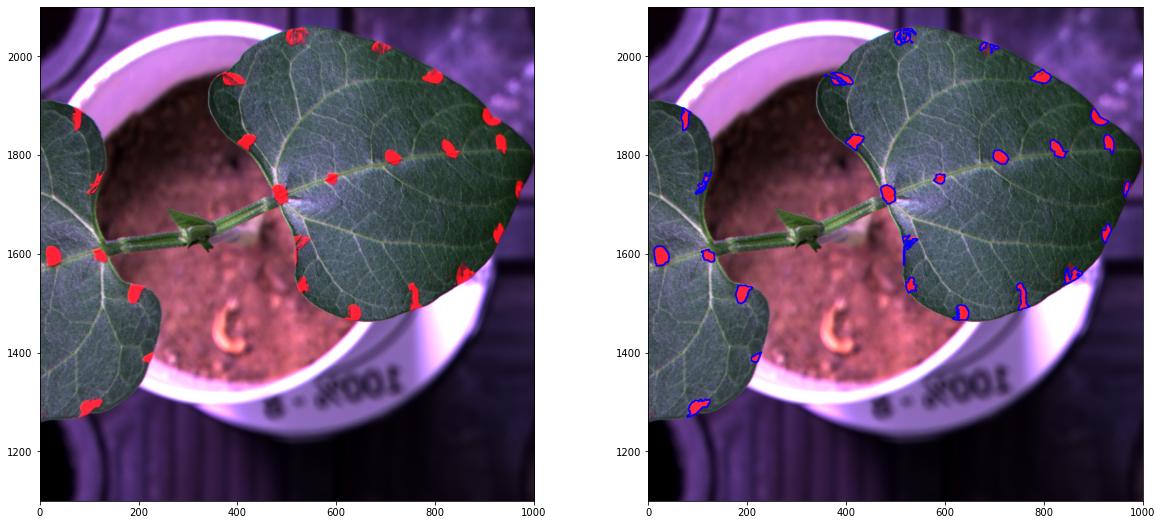

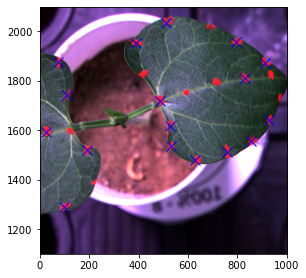

In [6]:
###############################################################################
# DETECTIE DOTS + X MIDDEN (SCRIPT JORIS)
###############################################################################
fileIn = 'D:/2024_Marten-Thesis/Verwerking_images_RGB/L9/CLR_E3514P7708N0001_20240312.DAT'
image = rescale(read_RGB(fileIn), percentiles = None, to_uint8=True)

min_red = np.array([170, 0, 0])  # min. limit Red (RGB)
max_red = np.array([255, 80, 80])  # max. limit Red (RGB)
 
mask = cv2.inRange(image, min_red, max_red)
contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

min_contour_len = 50

centers = []
for contour in contours:
    if contour.shape[0] >= min_contour_len:
        centers += [np.mean(contour, axis=0)[0]]
centers = np.array(centers)

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(image)
plt.xlim([0,1000])
plt.ylim([1100,2100])

plt.subplot(222)
plt.imshow(image_with_contours)
plt.xlim([0,1000])
plt.ylim([1100,2100])
plt.figure(figsize=(20,10))

plt.subplot(223)
plt.imshow(image)
plt.scatter(centers[:,0], centers[:,1], marker='x', color = 'blue', s = 100, linewidth = 1)
plt.xlim([0,1000])
plt.ylim([1100,2100])

plt.show()

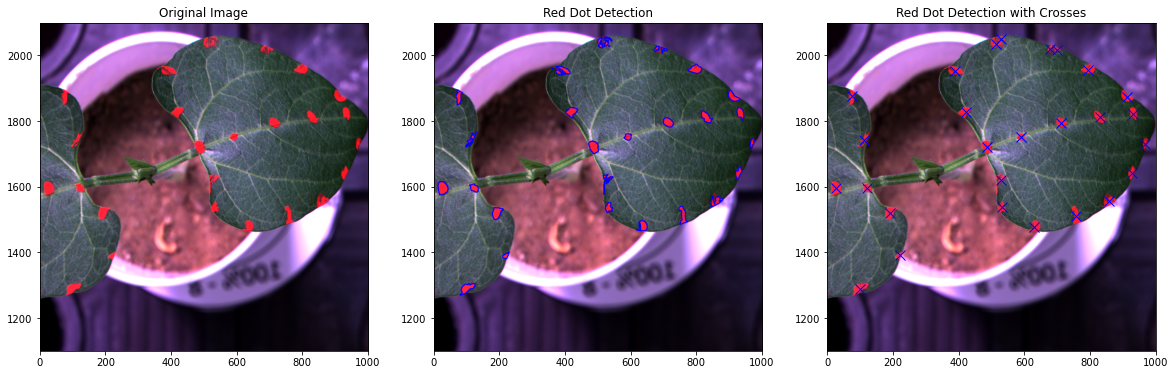

In [7]:
###############################################################################
# FUNCTIEBEPALING: DOT HERKENNING + KRUIS PLAATSEN
###############################################################################
def find_red_dot(fileIn):
    image = rescale(read_RGB(fileIn), percentiles=None, to_uint8=True)

    min_red = np.array([170, 0, 0])  # min. limit Red (RGB)
    max_red = np.array([255, 80, 80])  # max. limit Red (RGB)

    mask = cv2.inRange(image, min_red, max_red)
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

    min_contour_len = 30

    centers = []
    for contour in contours:
        if contour.shape[0] >= min_contour_len:
            centers += [np.mean(contour, axis=0)[0]]
    centers = np.array(centers)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.xlim([0, 1000])
    plt.ylim([1100, 2100])

    plt.subplot(1, 3, 2)
    plt.imshow(image_with_contours)
    plt.title('Red Dot Detection')
    plt.xlim([0, 1000])
    plt.ylim([1100, 2100])

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='blue', s=100, linewidth=1)
    plt.title('Red Dot Detection with Crosses')
    plt.xlim([0, 1000])
    plt.ylim([1100, 2100])

    plt.show()

fileIn = 'D:/2024_Marten-Thesis/Verwerking_images_RGB/L9/CLR_E3514P7708N0001_20240312.DAT'
find_red_dot(fileIn)

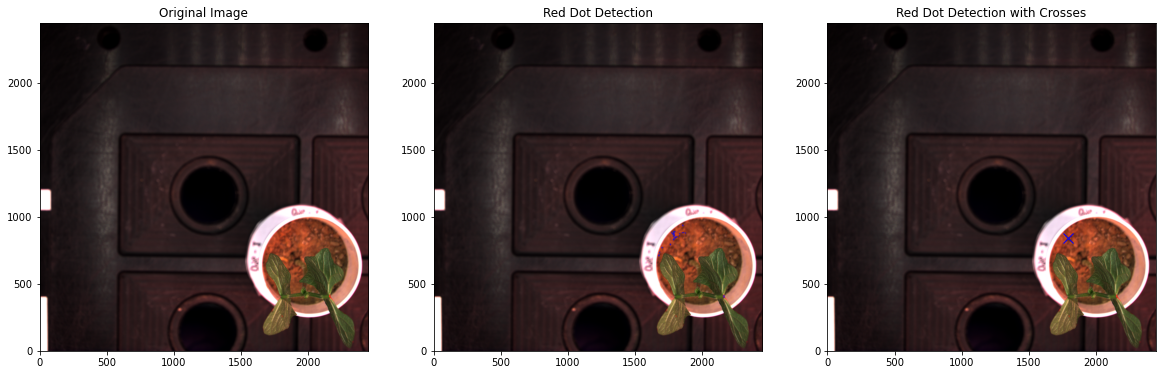

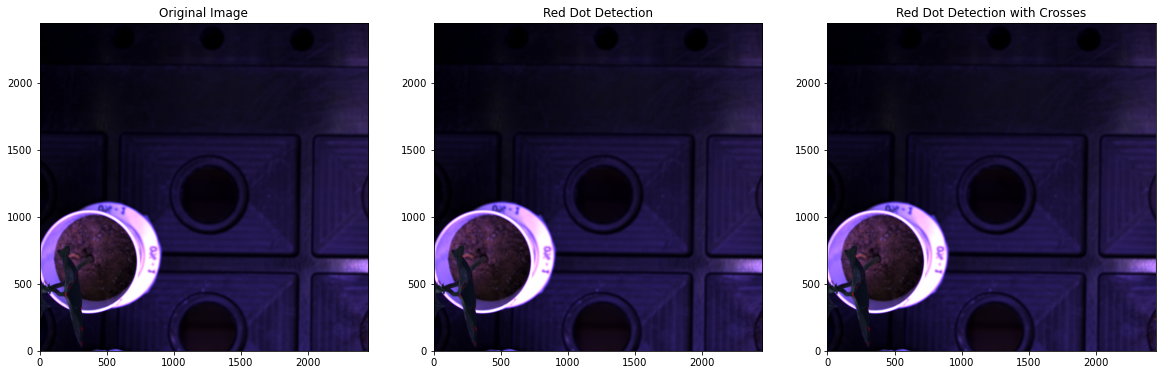

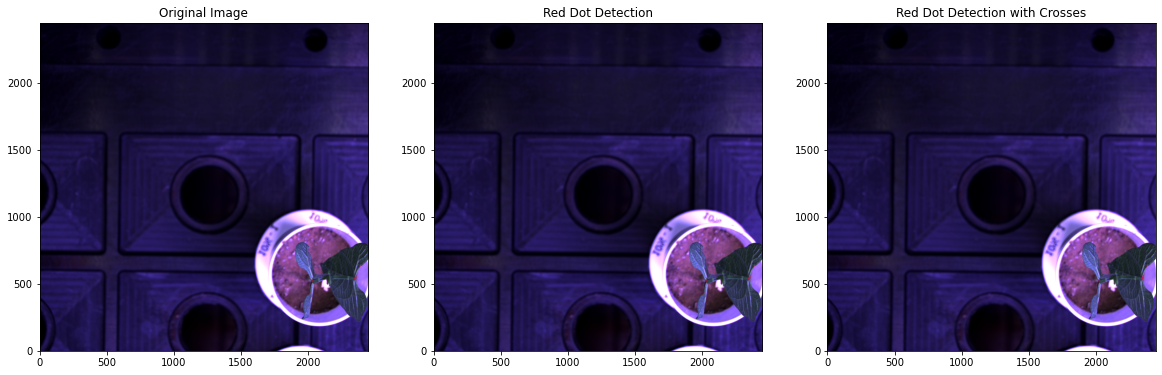

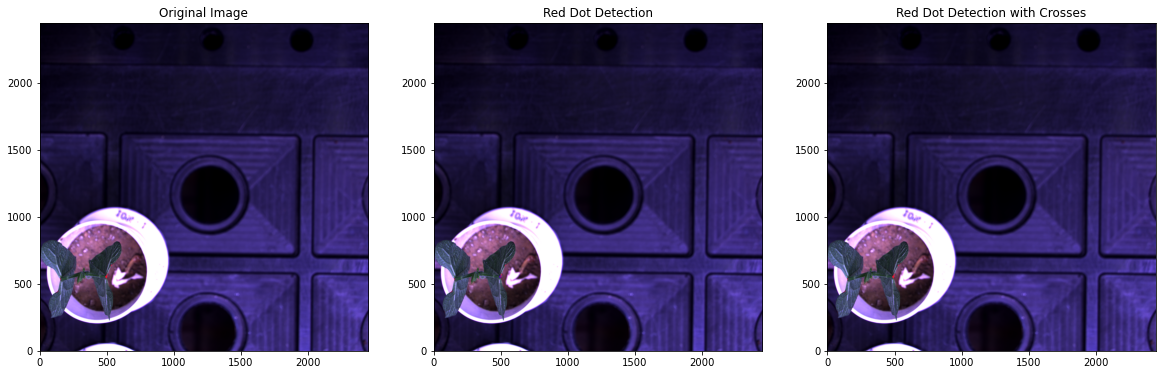

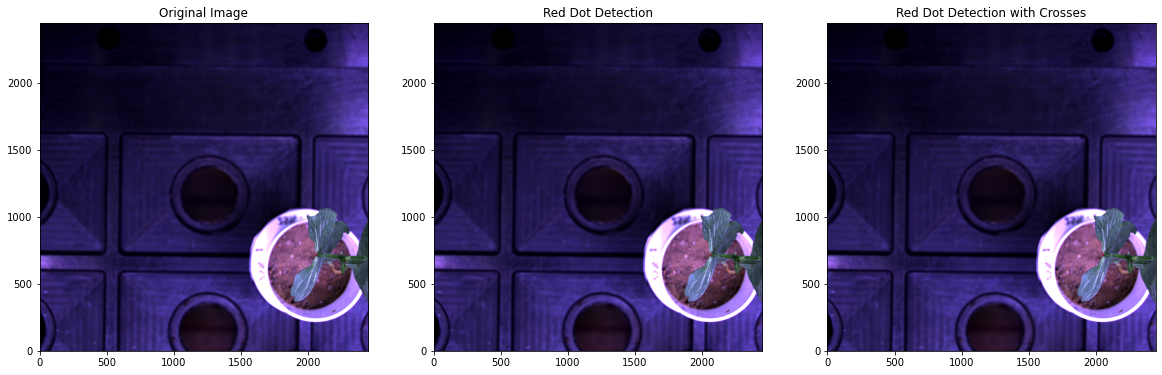

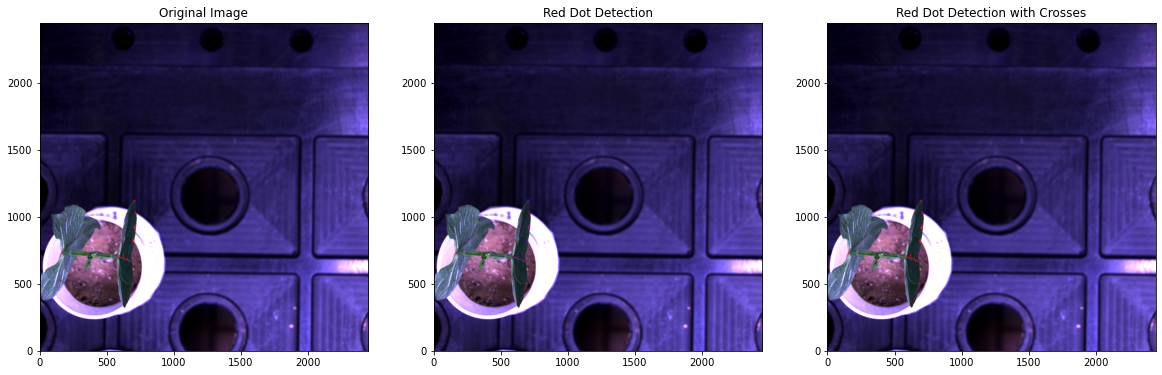

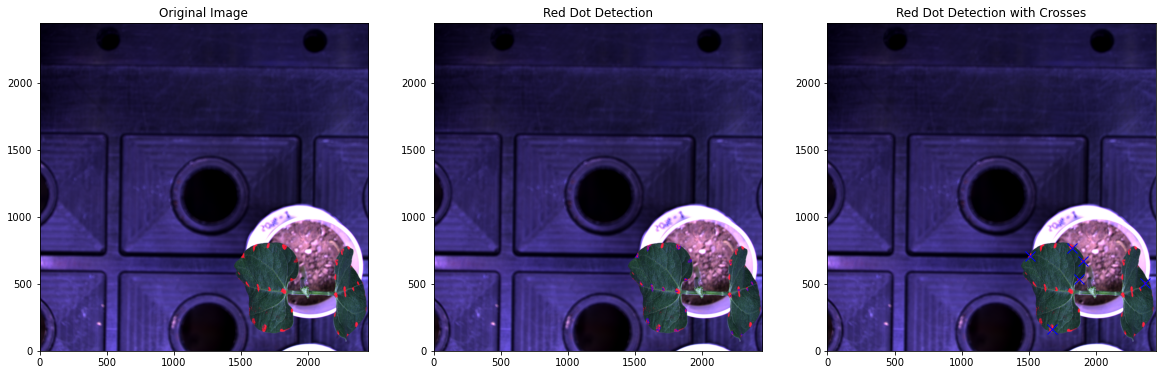

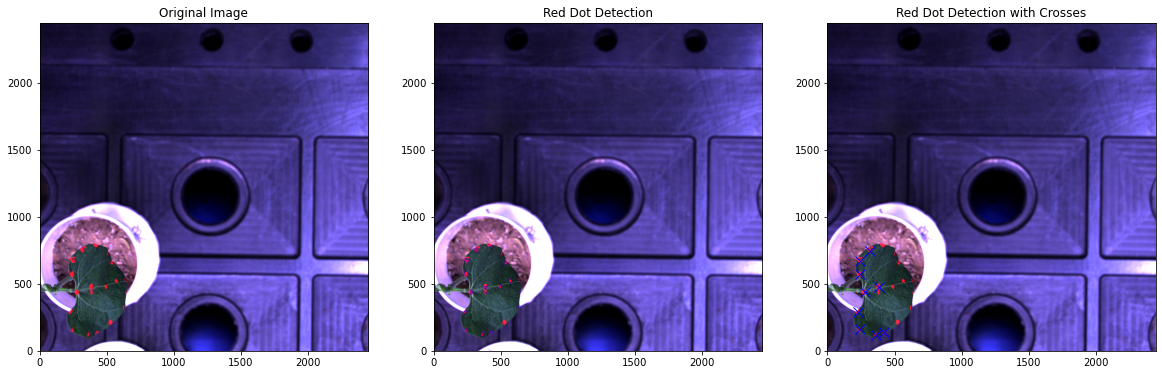

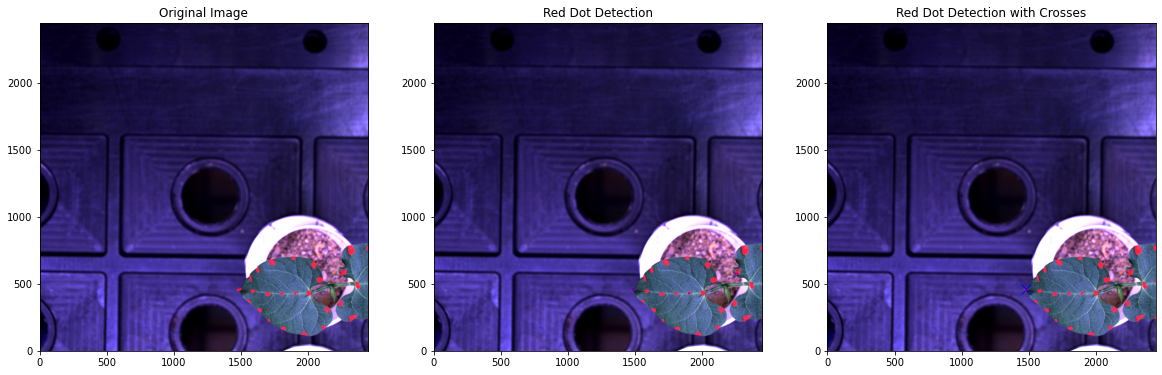

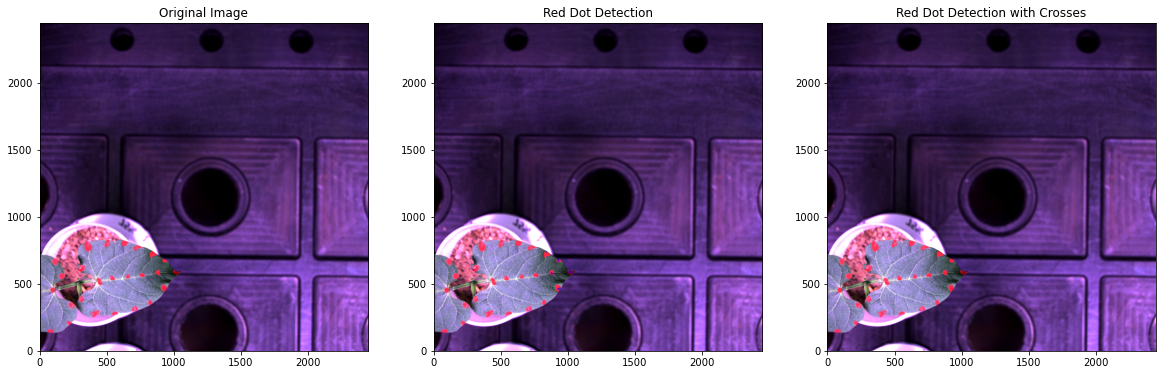

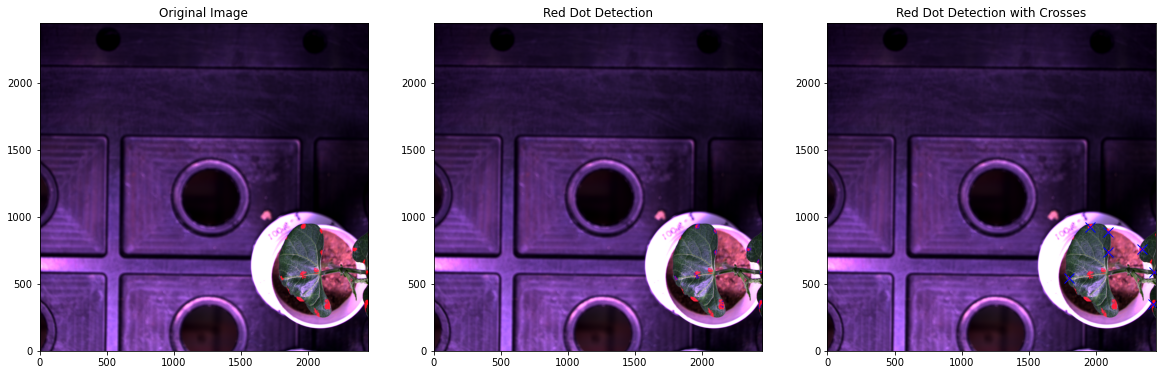

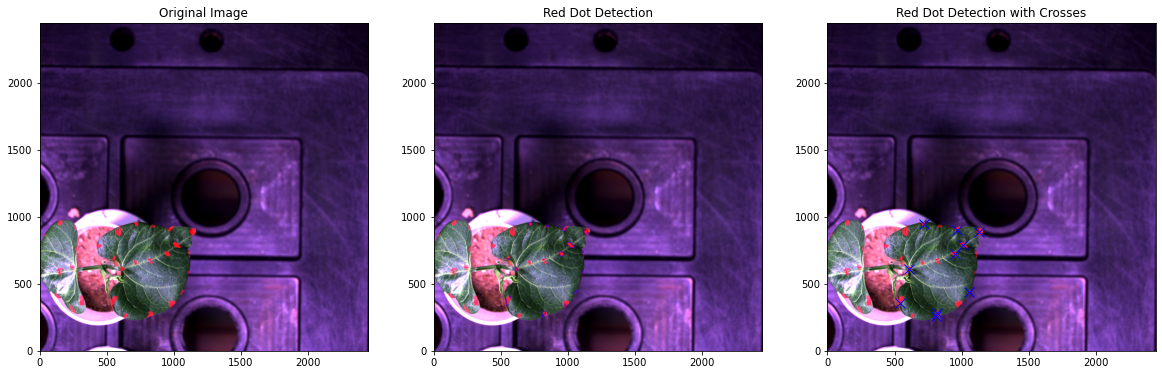

In [8]:
###############################################################################
# FUNCTIE OVER EEN VOLLEDIGE MAP PER KOLOM
###############################################################################
def find_red_dot(fileIn):
    image = rescale(read_RGB(fileIn), percentiles=None, to_uint8=True)

    min_red = np.array([140, 0, 0])  # min. limit Red (RGB)
    max_red = np.array([255, 60, 60])  # max. limit Red (RGB)

    mask = cv2.inRange(image, min_red, max_red)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

    min_contour_len = 30

    centers = []
    for contour in contours:
        if contour.shape[0] >= min_contour_len:
            center = np.mean(contour, axis=0)[0]
            if center.shape[0] == 2:  # Controleren op geldige array
                centers.append(center)
    centers = np.array(centers)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.xlim([0, image.shape[1]])
    plt.ylim([0, image.shape[0]])

    plt.subplot(1, 3, 2)
    plt.imshow(image_with_contours)
    plt.title('Red Dot Detection')
    plt.xlim([0, image.shape[1]])
    plt.ylim([0, image.shape[0]])

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    if centers.shape[0] > 0 and centers.shape[1] == 2:  # Controleren op geldige array
        plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='blue', s=100, linewidth=1)
    plt.title('Red Dot Detection with Crosses')
    plt.xlim([0, image.shape[1]])
    plt.ylim([0, image.shape[0]])

    plt.show()

# Volledige kolom 1 van A1 tot L1 overlopen (respectievelijk voor andere kolommen komt door python maar 20 foto's kan openen)
directory = "D:/2024_Marten-Thesis/Opsplitsing/Kolom 1"

# Loop over elk bestand in de map
for fileIn in glob.glob(os.path.join(directory, "*.DAT")):
    # Roep find_red_dot aan voor elk bestand in de map
    find_red_dot(fileIn)